In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
from datetime import datetime
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook


sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

## Задание 1

Готовим данные

In [2]:
data = pd.read_csv('owid-covid-data.csv')

In [3]:
data_russia = data[data['location'] == 'Russia']

In [4]:
start_date = datetime.strptime('2020-03-02', '%Y-%m-%d')

In [5]:
start_date

datetime.datetime(2020, 3, 2, 0, 0)

In [6]:
data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_53764/645069586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_russia['days'] = data_russia['date'].transform(lambda x: (datetime.strptime(x, '%Y-%m-%d') - start_date).days)


In [7]:
data_russia = data_russia[data_russia['days'] > 0]

In [8]:
data_russia['new_cases'] = data_russia['new_cases'].transform(lambda x: 1 if x == 0 else x)

In [9]:
train_data_russia = data_russia[data_russia['days'] <= 50]
test_data_russia = data_russia[data_russia['days'] > 50]

## Задание 2

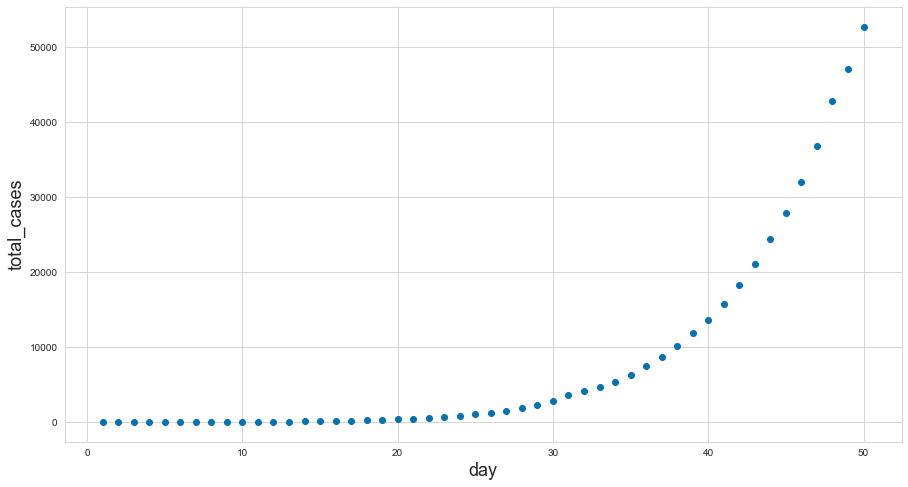

In [10]:
%matplotlib inline
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('total_cases', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

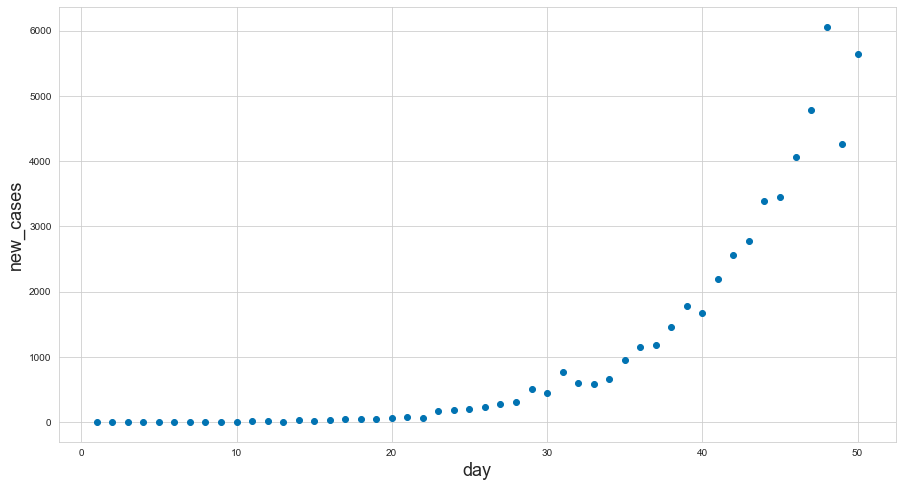

In [11]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('new_cases', fontsize=18)
ax.set_xlabel('day', fontsize=18)
plt.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy())
plt.show()

### 2.a

Для обучения модели в предположении экспоненциальности роста числа заболевших прологарифмируем целевую переменную

In [12]:
train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_53764/1381735601.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['total_cases'] = train_data_russia['total_cases'].transform(lambda x: math.log(x))


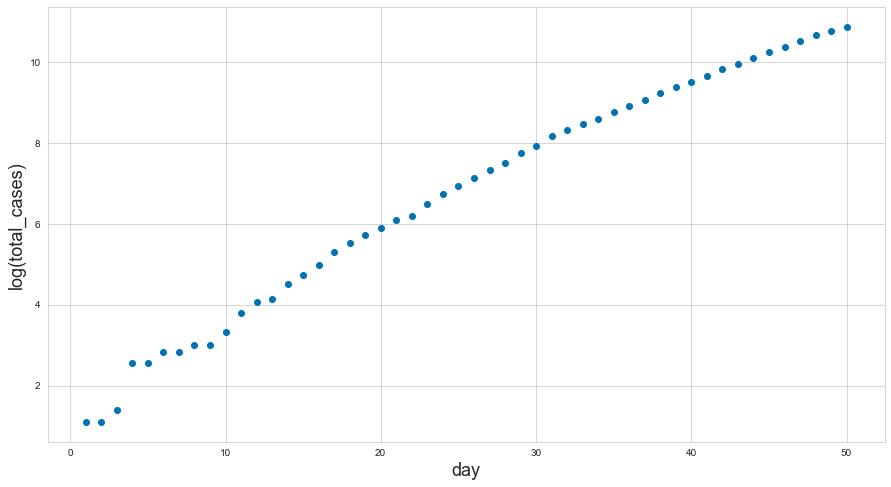

In [13]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('log(total_cases)', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy())
plt.show()

Как мы видим после логарифмирования зависимости целевых переменных от дней стали квазилинейными. Таким образом, можно попытаться обучить линейную модель.

In [14]:
exp_model = LinearRegression()
exp_model.fit(train_data_russia['days'].to_numpy().reshape(-1, 1), train_data_russia['total_cases'])

LinearRegression()

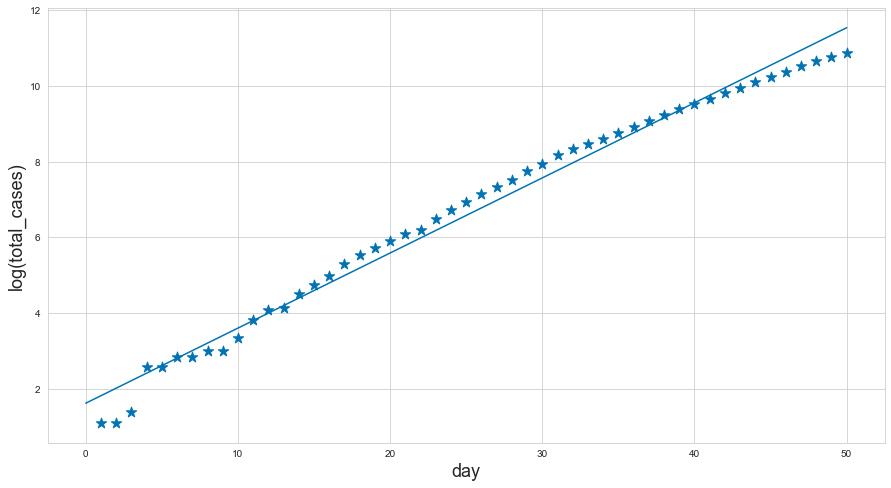

In [15]:
def predicted_curve(x):
    return x * exp_model.coef_ + exp_model.intercept_

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('log(total_cases)', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.plot([0] + list(train_data_russia['days'].to_numpy()), predicted_curve([0] + list(train_data_russia['days'].to_numpy())))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 2.b

Оценим дисперсию шума в данных исходя из параметров полученной модели:

In [16]:
def get_disp(X, Y, w0, w1):
    return np.sum((Y - w0 - X * w1)**2) / len(X)

In [17]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), exp_model.intercept_, exp_model.coef_)

In [18]:
sigma = math.sqrt(disp)

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [19]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [20]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [21]:
def plot_w_space_heatmap(X, Y, sigma, w0_lim=[-1, 1], w1_lim=[-1, 1]):
    w0 = np.linspace(w0_lim[0], w0_lim[1], 1000)
    w1 = np.linspace(w1_lim[0], w1_lim[1], 1000)
    w0, w1 = np.meshgrid(w0, w1)
    pos = np.empty(w0.shape + (2,))
    pos[:, :, 0] = w0
    pos[:, :, 1] = w1
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim((w1_lim[0], w1_lim[1]))
    ax.set_xlim((w0_lim[0], w0_lim[1]))
    ax.set_ylabel('W1', fontsize=18)
    ax.set_xlabel('W0', fontsize=18)
    p = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    ax.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


In [22]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma)

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_53764/355986512.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(w0, w1, p, cmap=plt.cm.jet)


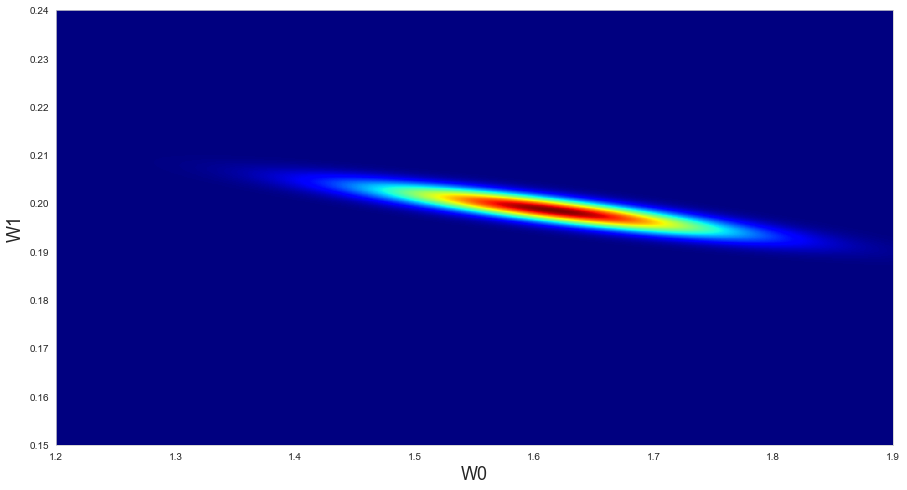

In [23]:
plot_w_space_heatmap(train_data_russia['days'].to_numpy(), train_data_russia['total_cases'].to_numpy(), sigma, [1.2, 1.9], [0.15, 0.24])

### 2.c

In [24]:
def plot_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    for w in my_w:
        ax.plot(xs, np.exp(w[0] + w[1]*xs), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60), math.exp(w[0] + w[1]*91), math.exp(w[0] + w[1]*183))
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)

In [25]:
def plot_new_cases_sample_exponents(sigma, n=20, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    for w in my_w:
        ax.plot(xs, np.exp(w[0] + w[1]*xs) - np.exp(w[0] + w[1]*(xs - 1)), 'k-', lw=.4)
        print(math.exp(w[0] + w[1]*60) - math.exp(w[0] + w[1]*59),
              math.exp(w[0] + w[1]*91) - math.exp(w[0] + w[1]*90),
              math.exp(w[0] + w[1]*183) - math.exp(w[0] + w[1]*182))
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)

959083.4709597995 555159359.3733422 8.7697369214802e+16
772563.7086684987 378808439.5123058 3.65667047440835e+16
701349.4114194753 306604668.40170753 2.10537599614916e+16
834881.522956706 434684604.56055987 5.014086944009192e+16
751175.7820500352 362014310.93731904 3.3199408566652556e+16
745599.47168585 355094165.30111337 3.1439490627441716e+16
747986.7971705872 365593973.90616196 3.4959804267332424e+16
464801.1944083817 152199423.7267268 4433192516722728.0
717002.531283822 326825915.33500654 2.5405998707527004e+16
780767.0170062189 381773592.32597864 3.655173966078221e+16
734670.2764111105 329674240.14325136 2.446326956259478e+16
896389.2486139978 466935597.81682307 5.393871438122833e+16
750672.4778071112 351262778.3849994 2.951495712379617e+16
909158.0007035844 475593685.6261395 5.563262555240277e+16
709966.6517866811 351336349.064596 3.4854560548584216e+16
748314.9986516278 345799293.06549335 2.7995208790488268e+16
906180.0149179985 487771480.2481254 6.210482450952607e+16
733124.863

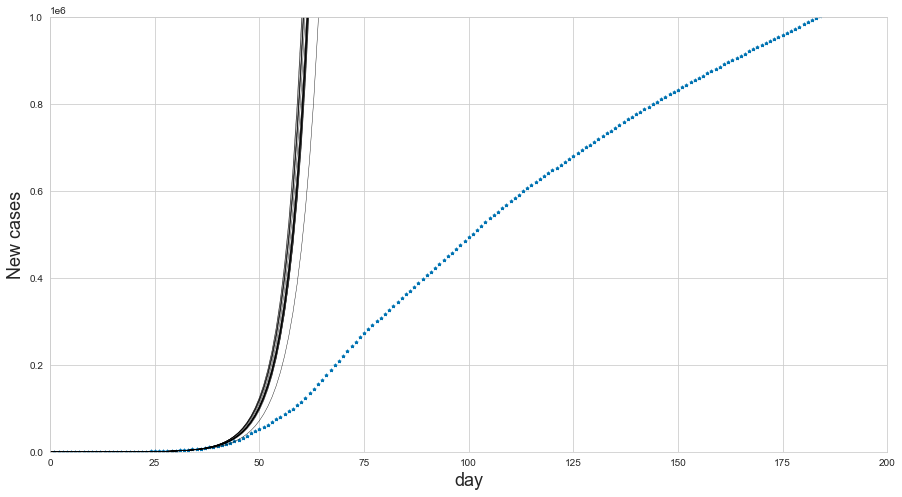

In [26]:
plot_sample_exponents(sigma, 20, xlim=(0, 200), ylim=(0, 1000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

Полученная модель предсказывает более 600000 случаев заражения к 1 мая, более 300000000 к 1 июня и более 10^16 к 1 сентября, что, как мы видим, на деле оказалось не так. С новыми случаями заражения ситуация идентичная:

131498.1932758073 63079337.416008234 5705665623365464.0
136513.33481541078 66497753.11398423 6295132186633812.0
130891.12079910072 62330945.55564219 5517011188042960.0
111700.58644843602 46331018.19221705 2721919823191190.0
159516.73679883487 81776057.78581089 9008912442479736.0
165127.49795606488 92194353.62325013 1.3084282215715128e+16
137948.36727045965 65398419.19480717 5712175536550408.0
117298.5706562628 51270797.09831178 3519023790819766.0
167320.20888349006 86526498.37817705 9781733199924144.0
119220.29243376246 53585033.73091015 3995330705283564.0
118559.54395695636 51607790.74111757 3498884579004948.0
143669.9982777806 72293051.54990268 7535904267828212.0
115468.4488442418 48394507.66438508 2932263064253630.0
111513.22215921595 48847075.706166625 3374155637805450.0
111796.99557773909 47250020.56323314 2935004962393870.0
153382.6847518792 77047624.48362637 7990602481910980.0
157795.78440861113 83409412.0987814 1.0063092872580424e+16
121910.44145722152 54953071.921779096 413269

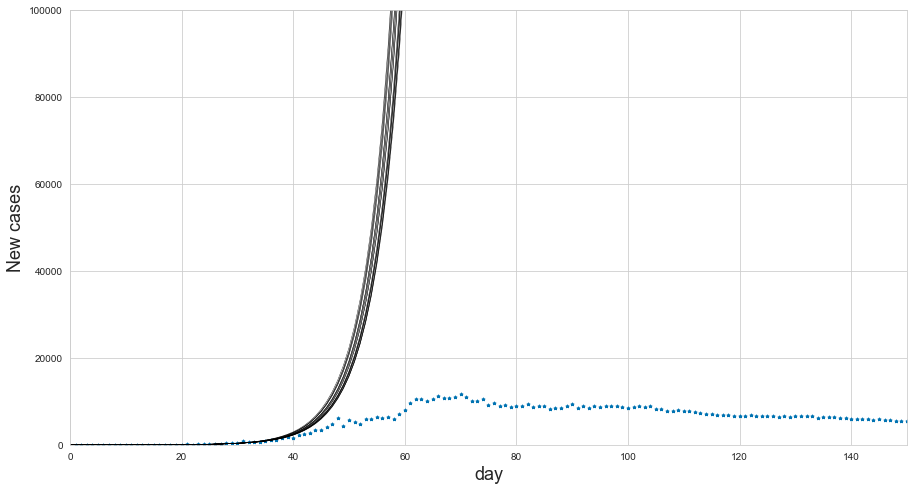

In [27]:
plot_new_cases_sample_exponents(sigma, 20, xlim=(0, 150), ylim=(0, 100000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения

In [28]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
    return res

In [29]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Total cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0]), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] - sigma), np.exp(mu[1]*days_arr + mu[0] + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

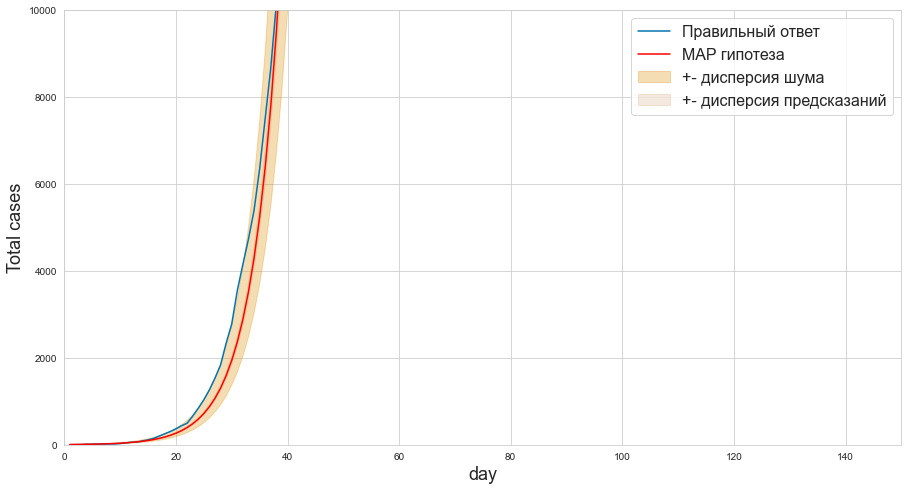

In [30]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred)

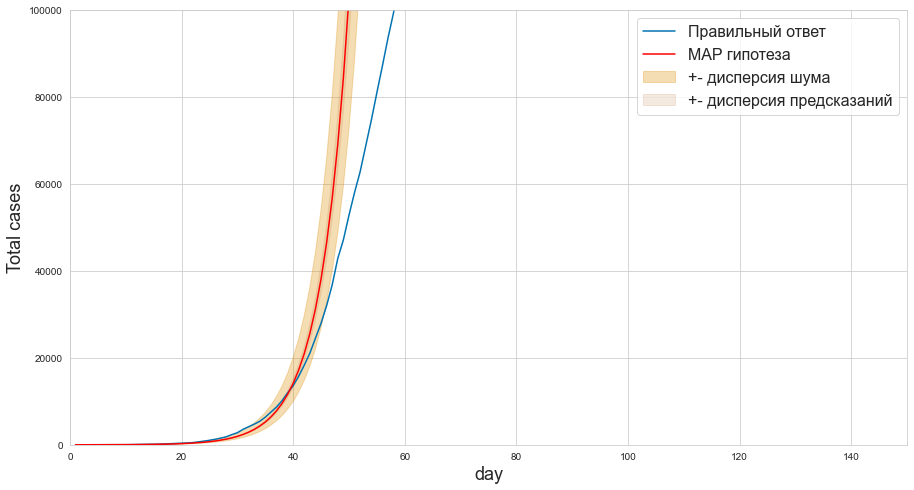

In [31]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 150), ylim=(0, 100000))

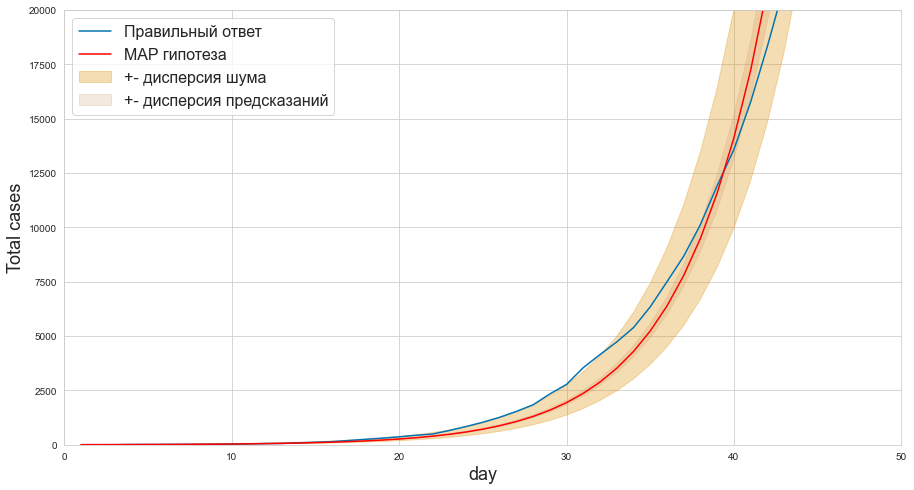

In [32]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 50), ylim=(0, 20000))

## Задание 3

### 3.a

Возьмем производную от Ф(x) ("физический смысл" - скорость прироста случаев) и в качестве целевой переменной возьмём new_cases. Тогда $ln(y) \propto w_0 + w_1 x + w_2 x^2$

Логарифмируем целевую переменную:

In [33]:
train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))

C:\Users\ALEXAN~1\AppData\Local\Temp/ipykernel_53764/402516223.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_russia['new_cases'] = train_data_russia['new_cases'].transform(lambda x: math.log(x))


In [34]:
train_data_new = pd.DataFrame()
train_data_new['days'] = train_data_russia['days']
train_data_new['days_2'] = train_data_new['days']**2

Обучаем модель:

In [35]:
probit_model = LinearRegression()
probit_model.fit(train_data_new, train_data_russia['new_cases'])

LinearRegression()

In [36]:
probit_model.coef_

array([ 0.27928241, -0.00182979])

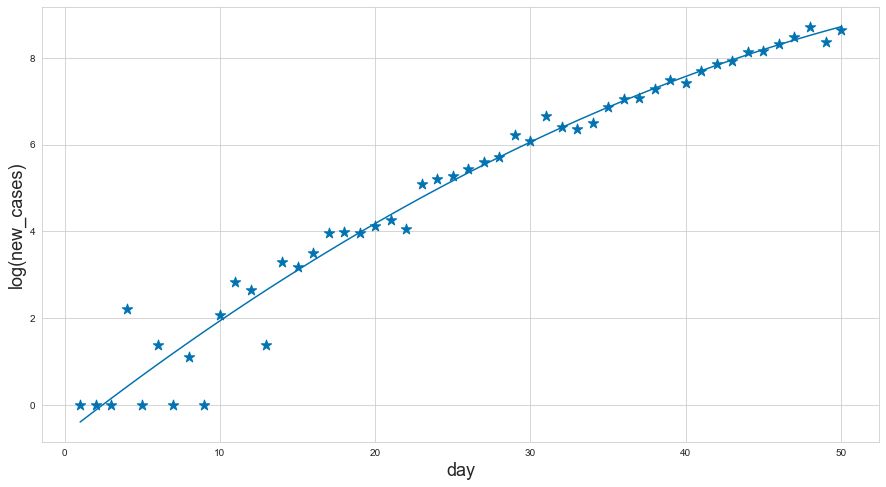

In [37]:
def predicted_curve(x):
    return probit_model.intercept_ + x * probit_model.coef_[0] + x**2 * probit_model.coef_[1]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_ylabel('log(new_cases)', fontsize=18)
ax.set_xlabel('day', fontsize=18)
ax.plot(train_data_russia['days'].to_numpy(), predicted_curve(train_data_russia['days'].to_numpy()))
ax.scatter(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), marker='*', s=120)
plt.show()

### 3.b

Найдём апостериорное распределение параметров модели для достаточно широкого априорного распределения

In [38]:
def get_disp(X, Y, w0, w1, w2):
    return np.sum((Y - w0 - X * w1 - X**2 * w2)**2) / len(X)

In [303]:
disp = get_disp(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), probit_model.intercept_, probit_model.coef_[0], probit_model.coef_[1])

In [304]:
sigma = math.sqrt(disp)

In [311]:
def bayesian_update(mu, sigma, x, y, sigma_noise=.25):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [317]:
def get_posterior(X, Y, sigma):
    cur_mu, cur_sigma = np.array([0, 0, 0]), 2*np.array([[5, 0, 0], [0, 5, 0], [0, 0, 5]])
    for idx in range(len(X)):
        cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, X[idx], Y[idx], sigma)
    return cur_mu, cur_sigma

In [318]:
cur_mu, cur_sigma = get_posterior(train_data_russia['days'].to_numpy(), train_data_russia['new_cases'].to_numpy(), sigma)

### 3.c

In [319]:
def plot_sample_sigmoids(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=1000, days=None, cases=None):
    cases_num = [[], [], [], []]
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for w in my_w:
        ax.plot(xs, np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2)), 'k-', lw=.4)
        cases_num[0].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[60])
        cases_num[1].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[91])
        cases_num[2].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[183])
        cases_num[3].append(np.cumsum(np.exp(w[0] + w[1]*xs + w[2]*xs**2))[999])
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Total cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)
    return cases_num

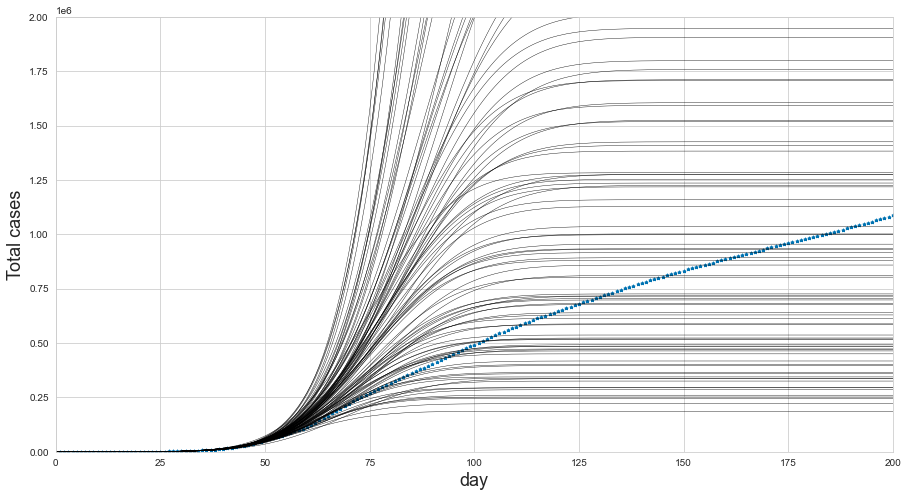

In [320]:
cases_num = plot_sample_sigmoids(sigma, 100, xlim=(0, 200), ylim=(0, 2000000), days=data_russia['days'].to_numpy(), cases=data_russia['total_cases'].to_numpy())

In [321]:
['1.05.2020', '1.06.2020', '1.09.2020']
for i in range(4):
    print(np.percentile(cases_num[i], 10), np.percentile(cases_num[i], 90))

118245.23903117733 213633.11152091244
324995.4742628935 2484591.1881286902
338160.5672553318 6695747.349156124
338160.5672553426 6695826.0685602985


Из полученных результатов можно сделать вывод, что в оптимистичном сценарии (10-й процентиль) в России будет порядка 338000 случаев, в пессимистичном сценарии (90-й процентиль) - порядка 6700000.

In [322]:
def plot_new_cases(sigma, n=100, xlim=(0, 200), ylim=(0, 10000), days_to_show=200, days=None, cases=None):
    my_w = np.random.multivariate_normal(cur_mu, cur_sigma, n)
    xs = np.arange(days_to_show)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for w in my_w:
        ax.plot(xs, np.exp(w[0] + w[1]*xs + w[2]*xs**2), 'k-', lw=.4)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    if days is not None:
        ax.scatter(days, cases, marker='*', s=10)

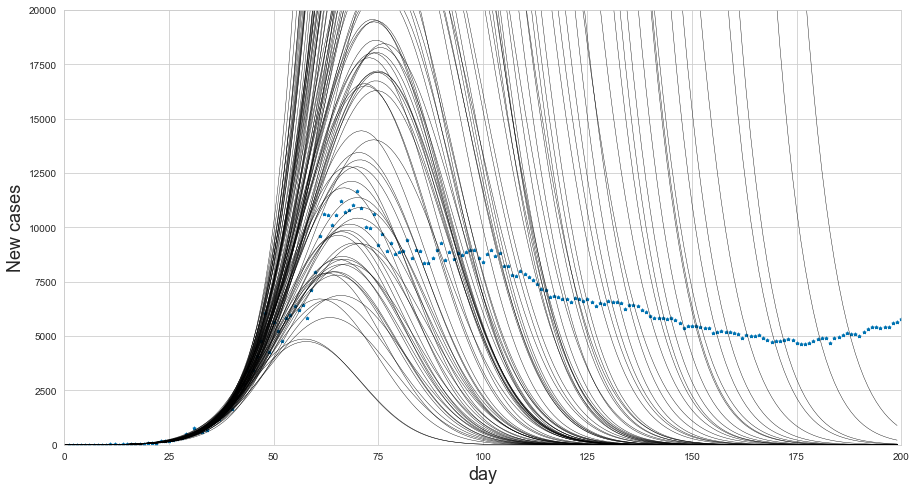

In [323]:
plot_new_cases(sigma, 100, xlim=(0, 200), ylim=(0, 20000), days=data_russia['days'].to_numpy(), cases=data_russia['new_cases'].to_numpy())

Построим предсказательные распределения:

In [324]:
def sample_statistics(mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    for i,w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs + w[2]*xs**2
    return res

In [325]:
def plot_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('Total cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2)), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma)), np.cumsum(np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma)), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.cumsum(np.mean(np.exp(predictions), axis=0)) - np.cumsum(np.std(np.exp(predictions), axis=0)), np.cumsum(np.mean(np.exp(predictions), axis=0)) + np.cumsum(np.std(np.exp(predictions), axis=0)), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

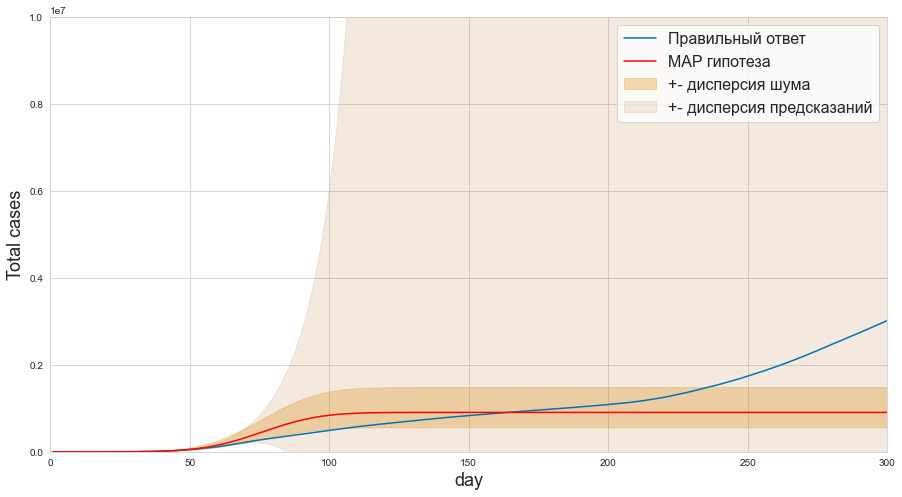

In [326]:
pred = sample_statistics(cur_mu, cur_sigma, data_russia['days'].to_numpy(), n=1000)
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 300), ylim=(0, 10000000))

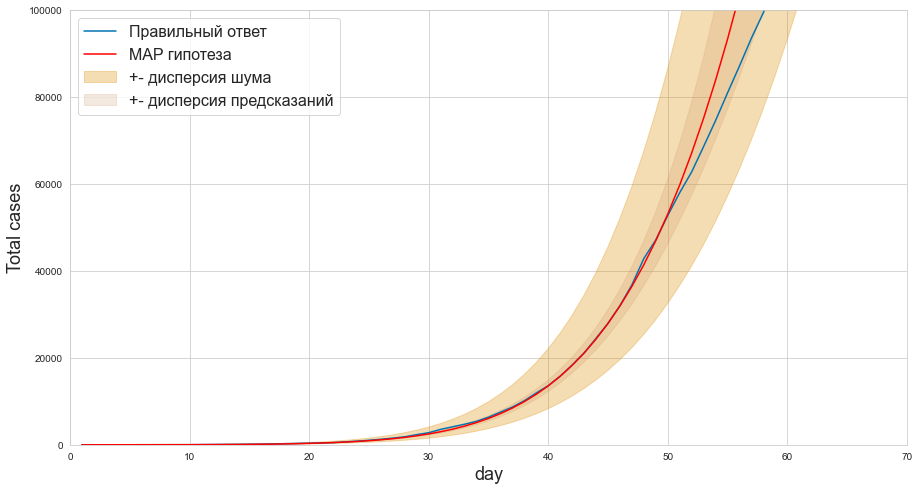

In [335]:
plot_predictions(data_russia['days'].to_numpy(), data_russia['total_cases'].to_numpy(), cur_mu, pred, xlim=(0, 70), ylim=(0, 100000))

In [333]:
def plot_new_cases_predictions(days_arr, real_values, mu, predictions, xlim=(0, 150), ylim=(0, 10000)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel('New cases', fontsize=18)
    ax.set_xlabel('day', fontsize=18)
    ax.plot(days_arr, real_values, label="Правильный ответ")
    ax.plot(days_arr, np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2), color="red", label="MAP гипотеза")
    ax.fill_between(days_arr, np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 - sigma), np.exp(mu[1]*days_arr + mu[0] + mu[2]*days_arr**2 + sigma), color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(days_arr, np.mean(np.exp(predictions), axis=0) - np.std(np.exp(predictions), axis=0), np.mean(np.exp(predictions), axis=0) + np.std(np.exp(predictions), axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.legend(fontsize=legend_fontsize)

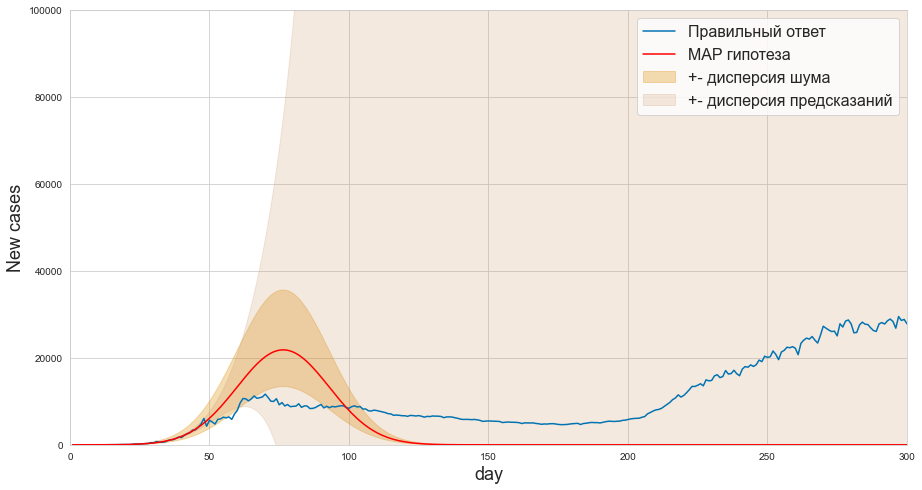

In [334]:
plot_new_cases_predictions(data_russia['days'].to_numpy(), data_russia['new_cases'].to_numpy(), cur_mu, pred, xlim=(0, 300), ylim=(0, 100000))

# Задание 4

In [3]:
data_full = pd.read_csv('owid-covid-data-full.csv')

In [4]:
countries = data_full['location'].unique()

In [5]:
countries

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [6]:
def convert_date_to_days_count(date, start_date):
    try:
        return (datetime.strptime(date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')).days
    except:
        return None

def get_params_for_country(data_full, country):
    data_for_country = data_full[data_full['location'] == country]
    data_for_country = data_for_country[data_for_country['total_cases'] > 2]
    data_for_country['days'] = data_for_country['date'].transform(lambda x: convert_date_to_days_count(x, '2020-01-01'))
    min_day = data_for_country['days'].min()
    data_for_country = data_for_country[data_for_country['days'] != None]
    data_for_country['days'] = data_for_country['days'].transform(lambda x: x - min_day)
    data_for_country.dropna(subset=['new_cases'], inplace=True)
    data_for_country['new_cases'] = data_for_country['new_cases'].transform(lambda x: 1 if x <= 0 else x)
    data_for_country['new_cases'] = data_for_country['new_cases'].transform(lambda x: math.log(x))
    data_for_country_x = pd.DataFrame()
    data_for_country_x['days'] = data_for_country['days']
    data_for_country_x['days_2'] = data_for_country['days']**2
    
    probit_model = LinearRegression()
    if len(data_for_country_x) == 0:
        return None
    probit_model.fit(data_for_country_x, data_for_country['new_cases'])
    return [probit_model.intercept_, probit_model.coef_[0], probit_model.coef_[1]]

W = []
mask = []
for country in countries:
    w = get_params_for_country(data_full, country)
    if w is not None:
        W.append(w)
        mask.append(True)
    else:
        mask.append(False)

In [7]:
c = []
for i in range(len(countries)):
    if mask[i]:
        c.append(countries[i])

In [8]:
W0 = []
W1 = []
W2 = []
for w0, w1, w2 in W:
    W0.append(w0)
    W1.append(w1)
    W2.append(w2)

<IPython.core.display.Javascript object>


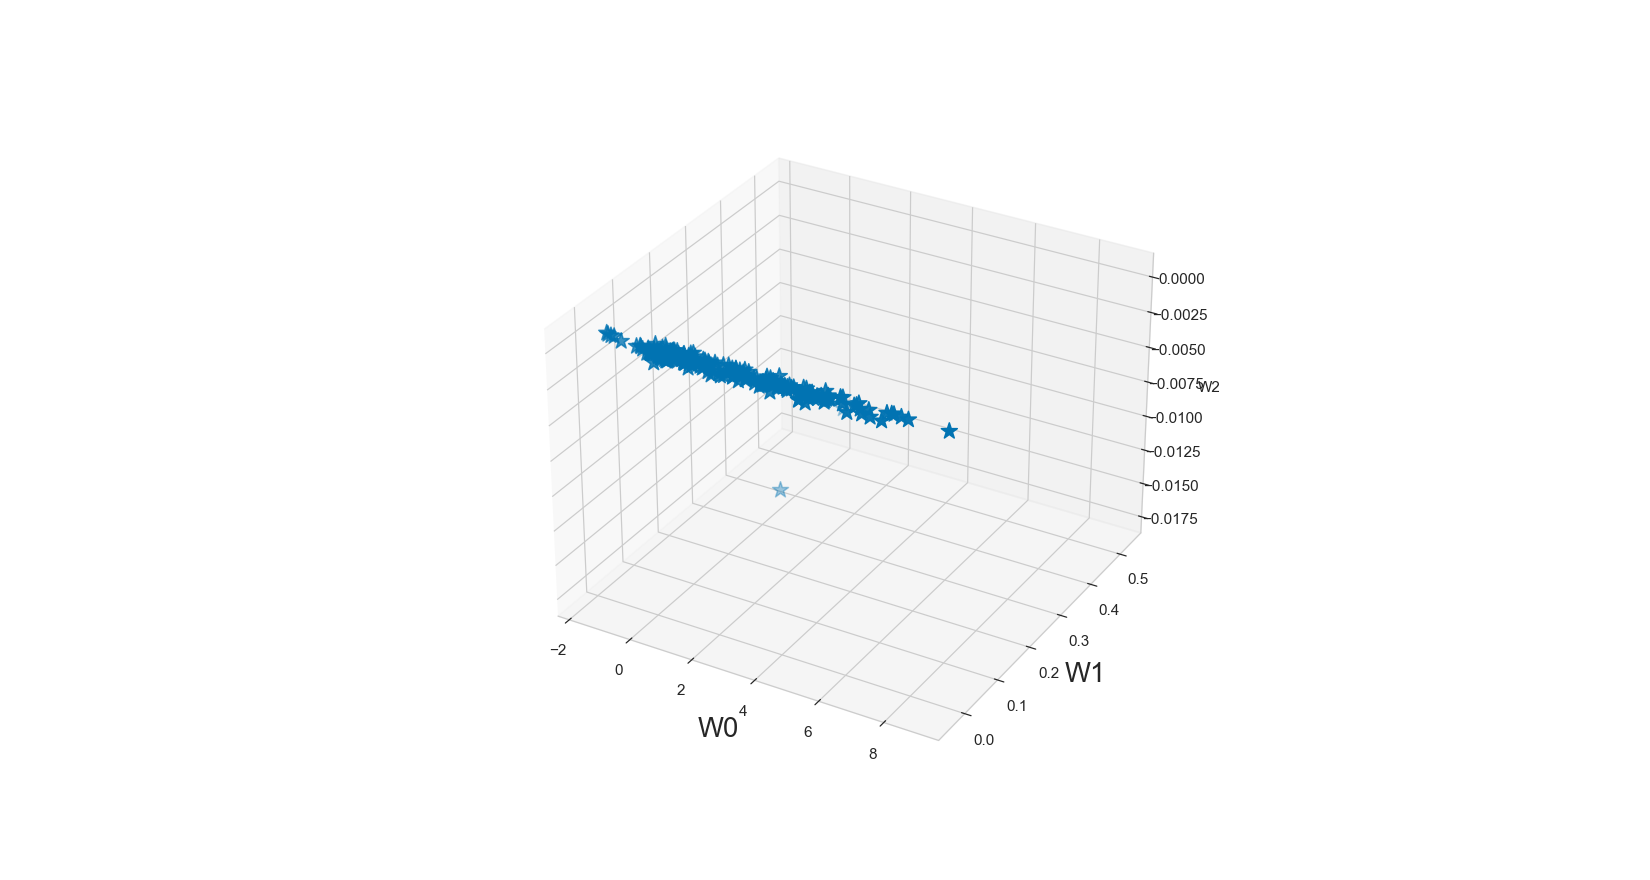

In [9]:
%matplotlib widget
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('W0', fontsize=18)
ax.set_ylabel('W1', fontsize=18)
ax.set_zlabel('W2')
ax.scatter(W0, W1, W2, marker='*', s=120)

plt.show()

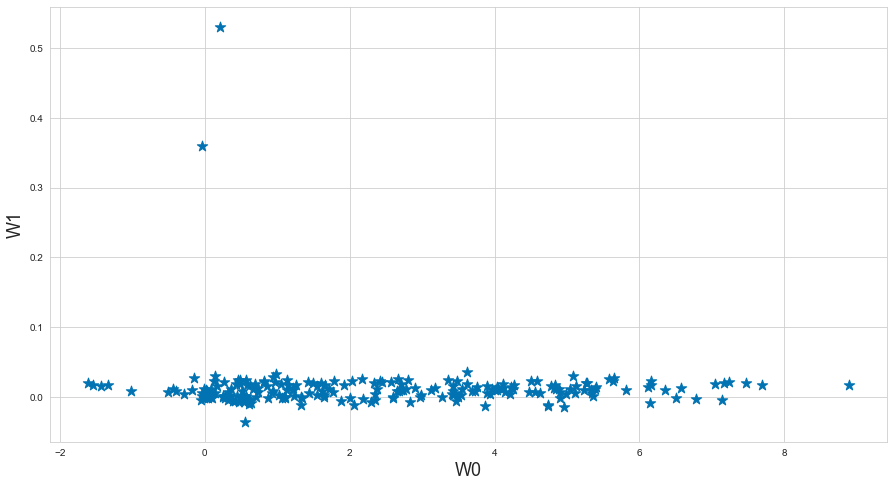

In [10]:
%matplotlib inline
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_xlabel('W0', fontsize=18)
ax.set_ylabel('W1', fontsize=18)
ax.scatter(W0, W1, marker='*', s=120)
plt.show()

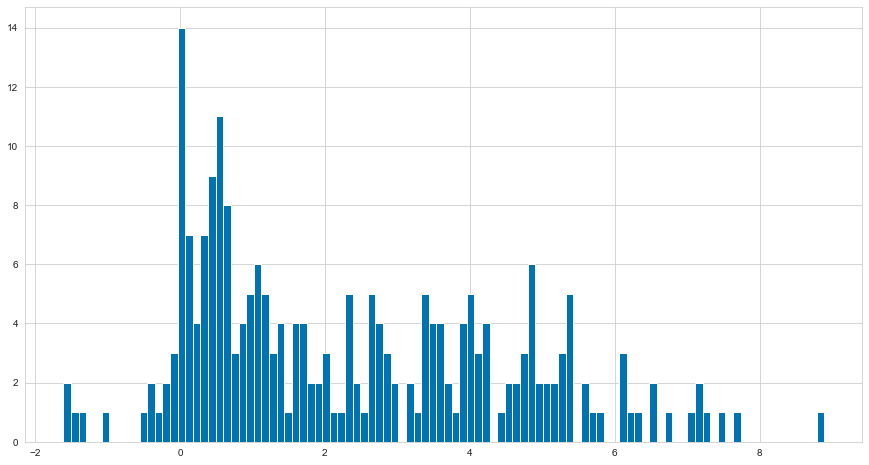

In [11]:
%matplotlib inline
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.hist(W0, bins=100)
plt.show()

In [56]:
world = gpd.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [57]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [58]:
data_full.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [62]:
country_to_w0 = {}
for idx, country in enumerate(c):
    country_to_w0[country] = W0[idx]
        

In [63]:
iso_code_to_w0 = {}
for record in data_full.to_dict('records'):
    if record['location'] in country_to_w0.keys() and record['location'] != 'World':
        iso_code_to_w0[record['iso_code']] = country_to_w0[record['location']]
    else:
        iso_code_to_w0[record['iso_code']] = None

In [64]:
world['W0'] = world['iso_a3'].map(iso_code_to_w0)

In [65]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,W0
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",-1.015812
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",0.595995
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",3.621254
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",5.584815


In [66]:
from  matplotlib.colors import LinearSegmentedColormap
cmap=LinearSegmentedColormap.from_list('rg',["g", "y", "r"], N=256) 

#### Распределение коэффициента $w_0$ по странам

<AxesSubplot:>

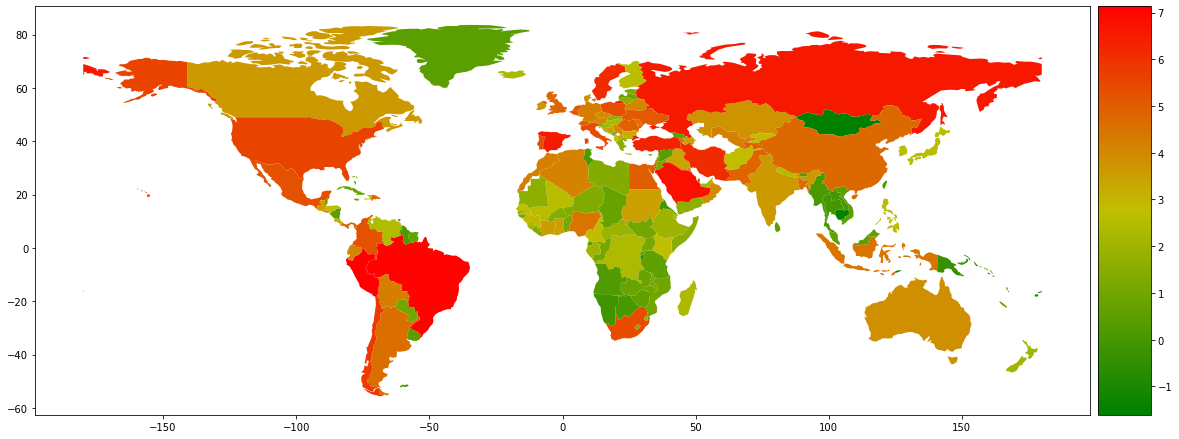

In [68]:
figsize = (20,12)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='W0', ax=ax, cmap=cmap, legend=True, cax=cax)

In [47]:
iso_to_total_cases = {}
iso_to_population = {}
for iso in data_full['iso_code'].unique():
    iso_to_total_cases[iso] = data_full[data_full['iso_code'] == iso]['total_cases'].max()
    iso_to_population[iso] = data_full[data_full['iso_code'] == iso]['population'].max()

In [48]:
world['total_cases'] = world['iso_a3'].map(iso_to_total_cases)
world['population'] = world['iso_a3'].map(iso_to_population)

#### Распределение общего числа случаев по странам

<AxesSubplot:>

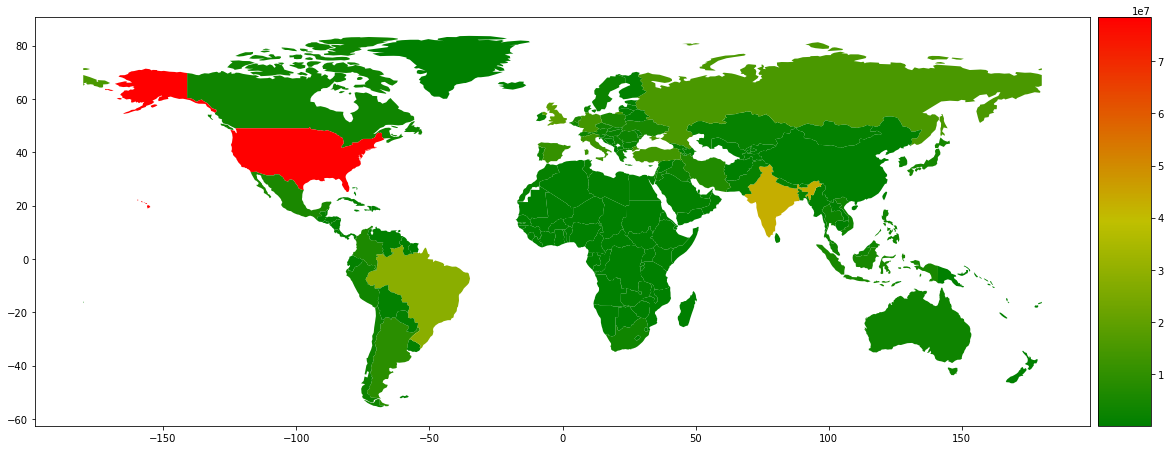

In [49]:
figsize = (20,12)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='total_cases', ax=ax, cmap=cmap, legend=True, cax=cax)

#### Распределение доли переболевшей популяции по странам

In [50]:
world['cases_percent'] = world['total_cases'] / world['population']

<AxesSubplot:>

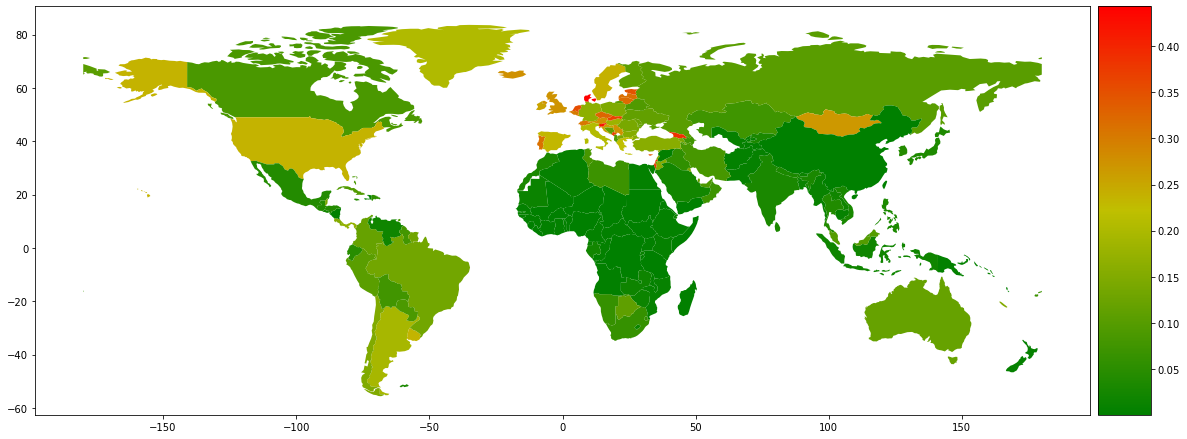

In [51]:
figsize = (20,12)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
world.plot(column='cases_percent', ax=ax, cmap=cmap, legend=True, cax=cax)